## Anomaly Detection: NoteBook 2: No PyTrends version
#### This Notebook attempts to use the only the US trending data CSV to solve for anomalies using several methods from sklearn and a keras application.

In [91]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pytrends as pt
from math import log
import numpy as np
from pytrends.request import TrendReq
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

In [92]:
data = pd.read_csv("US_youtube_trending_data.csv")

In [93]:
id_redundancies = data['video_id']
id_redundancies = id_redundancies.value_counts()
data['peaks'] = data['video_id'].apply(lambda x: id_redundancies.loc[x])

### As before, cleanup and feature engineering

In [94]:
data['post_date'] = data['publishedAt'].apply(lambda x: x.split("T")[0])
data['post_time'] = data['publishedAt'].apply(lambda x: x.split("T")[1])
data['post_time'] = data['post_time'].apply(lambda x: x[0:len(x)-1])
data['trend_date'] = data['trending_date'].apply(lambda x: x.split("T")[0])
data['title_len'] = data['title'].apply(lambda x: len(x))
data['ratio'] = data.apply(lambda x: x['likes']/(x['dislikes'] + 0.01), axis=1)
data['engagement'] = data.apply(lambda x: x['likes'] + x['comment_count'] + x['dislikes'], axis=1)
data['e/v'] = data.apply(lambda x: x['engagement']/x['view_count'], axis=1)
data['trend_week'] = data['trend_date'].apply(lambda x: pd.to_datetime(x).weekofyear)
data['trend_day'] = data['trend_date'].apply(lambda x: pd.to_datetime(x).dayofyear)
data['post_week'] = data['post_date'].apply(lambda x: pd.to_datetime(x).weekofyear)
data['post_day'] = data['post_date'].apply(lambda x: pd.to_datetime(x).dayofyear)
data['trend_lag'] = data.apply(lambda x: pd.to_datetime(x['trend_date']).dayofyear - pd.to_datetime(x['post_date']).dayofyear,axis=1)

In [95]:
data = data.drop(['trending_date', 'publishedAt', "thumbnail_link"], axis=1)
data = data.drop(['title'], axis=1) ##Since we know we can't search the title on pytrends
data = data.drop(['channelId'], axis=1)
data = data.drop(['description', 'comments_disabled', 'ratings_disabled'], axis=1)

In [96]:
data.columns

Index(['video_id', 'channelTitle', 'categoryId', 'tags', 'view_count', 'likes',
       'dislikes', 'comment_count', 'peaks', 'post_date', 'post_time',
       'trend_date', 'title_len', 'ratio', 'engagement', 'e/v', 'trend_week',
       'trend_day', 'post_week', 'post_day', 'trend_lag'],
      dtype='object')

In [97]:
data

,video_id,channelTitle,categoryId,tags,view_count,likes,dislikes,comment_count,peaks,post_date,...,trend_date,title_len,ratio,engagement,e/v,trend_week,trend_day,post_week,post_day,trend_lag
0,3C66w5Z0ixs,Brawadis,22,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,7,2020-08-11,...,2020-08-12,34,26.798929,198076,0.130777,33,225,33,224,1
1,M9Pmf9AB4Mo,Apex Legends,20,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,5,2020-08-11,...,2020-08-12,60,52.519139,166082,0.069733,33,225,33,224,1
2,J78aPJ3VyNs,jacksepticeye,24,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,7,2020-08-11,...,2020-08-12,53,134.621634,396636,0.194539,33,225,33,224,1
3,kXLn3HkpjaA,XXL,10,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,5,2020-08-11,...,2020-08-12,56,12.527411,32754,0.065934,33,225,33,224,1
4,VIUo6yapDbc,Mr. Kate,26,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,6,2020-08-11,...,2020-08-12,55,47.511955,48962,0.043565,33,225,33,224,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14193,ACzGSnVHjdo,JaVale McGee,22,JaVale McGee|Los Angeles Lakers|Golden State W...,1113891,72531,417,4549,4,2020-10-16,...,2020-10-21,93,173.931081,77497,0.069573,43,295,42,290,5
14194,Adwl0y3qKUI,Hollywood Undead,10,Hollywood Undead|hollywood undead heart of a c...,507587,46292,410,2681,3,2020-10-16,...,2020-10-21,89,112.904563,49383,0.097290,43,295,42,290,5
14195,vEnW8rLMJlc,Ty Dolla $ign,10,ty dolla $ign|ty dolla sign paranoid|ty dolla ...,884439,20792,284,472,3,2020-10-16,...,2020-10-21,70,73.208690,21548,0.024363,43,295,42,290,5
14196,4QJacjZyQHA,The Paul Becker Channel,24,Kenny Ortega|Booboo Stewart|Owen Joyner|Maddi ...,384655,19600,76,741,3,2020-10-16,...,2020-10-21,55,257.860808,20417,0.053079,43,295,42,290,5


In [98]:
categories = data['categoryId'].to_list()
categories=set(categories)
categories = list(categories)
categories

[1, 2, 10, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29]

In [99]:
data.corr()

,categoryId,view_count,likes,dislikes,comment_count,peaks,title_len,ratio,engagement,e/v,trend_week,trend_day,post_week,post_day,trend_lag
categoryId,1.000000,-0.092123,-0.107109,-0.064509,-0.070564,-0.021980,-0.018096,-0.059751,-0.101798,-0.126347,0.002385,0.005163,0.009951,0.007816,-0.026208
view_count,-0.092123,1.000000,0.919379,0.816765,0.762391,0.298535,-0.060714,-0.056538,0.918302,0.013539,0.002415,0.002628,-0.019012,-0.015529,0.178257
likes,-0.107109,0.919379,1.000000,0.795667,0.805310,0.254179,-0.085512,0.037204,0.990104,0.180675,-0.013636,-0.013618,-0.026442,-0.023759,0.100005
dislikes,-0.064509,0.816765,0.795667,1.000000,0.750305,0.167059,-0.025125,-0.075408,0.825614,0.043509,-0.042617,-0.042629,-0.052830,-0.050696,0.080498
comment_count,-0.070564,0.762391,0.805310,0.750305,1.000000,0.111404,-0.021782,-0.018803,0.879590,0.105309,-0.025440,-0.025663,-0.030693,-0.028594,0.029547
peaks,-0.021980,0.298535,0.254179,0.167059,0.111404,1.000000,-0.090064,-0.047174,0.229609,0.033174,-0.071989,-0.066773,-0.096466,-0.091352,0.243400
title_len,-0.018096,-0.060714,-0.085512,-0.025125,-0.021782,-0.090064,1.000000,-0.190750,-0.072614,-0.282454,0.027389,0.026727,0.027257,0.029367,-0.026730
ratio,-0.059751,-0.056538,0.037204,-0.075408,-0.018803,-0.047174,-0.190750,1.000000,0.022136,0.666598,0.028647,0.026711,0.035911,0.034751,-0.079759
engagement,-0.101798,0.918302,0.990104,0.825614,0.879590,0.229609,-0.072614,0.022136,1.000000,0.166270,-0.017883,-0.017919,-0.029436,-0.026794,0.087700
e/v,-0.126347,0.013539,0.180675,0.043509,0.105309,0.033174,-0.282454,0.666598,0.166270,1.000000,-0.025411,-0.026733,-0.008108,-0.009439,-0.169070


In [100]:
by_cat = data.groupby("categoryId").mean()

#### Note the categoreis are not evenly distributed. Even so, this appears to be a logical way to partition the classes, and as such, we will move forward with that assumption

In [101]:
c_count = data['categoryId'].value_counts()
c_count

10    3248
24    2632
17    1722
20    1242
22    1214
23     904
28     703
26     638
25     593
1      541
27     334
2      236
15     123
19      58
29      10
Name: categoryId, dtype: int64

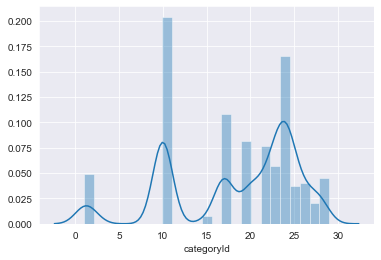

In [102]:
sns.distplot(data['categoryId'])

In [103]:
data.groupby("categoryId").std()

,view_count,likes,dislikes,comment_count,peaks,title_len,ratio,engagement,e/v,trend_week,trend_day,post_week,post_day,trend_lag
categoryId,,,,,,,,,,,,,,
1,2.612684e+06,9.954705e+04,2584.387086,8545.154127,1.249588,16.350782,122.597679,1.091344e+05,0.044029,2.893256,20.168544,2.866601,20.166150,1.771246
2,1.667478e+06,1.949681e+05,1078.370678,7234.627216,1.207263,19.805780,95.721576,2.022310e+05,0.043186,2.605689,18.204086,2.645148,18.307887,1.721394
10,1.494147e+07,1.104009e+06,53532.863357,335077.970911,2.489127,18.145551,89.220722,1.440330e+06,0.059079,2.971158,20.556520,2.940275,20.592628,2.360840
15,9.714276e+05,3.856115e+04,697.275681,3693.798371,0.946031,16.792284,47.198666,4.210287e+04,0.026181,2.585703,18.062123,2.764033,18.214341,1.733704
17,2.253058e+06,7.761153e+04,2028.267544,4935.159479,1.530230,21.876618,36.427198,8.305932e+04,0.019305,2.935481,20.430638,2.969832,20.488030,1.740835
19,2.190508e+05,9.555096e+03,184.289503,1333.006121,1.257043,16.242677,33.799686,1.069862e+04,0.026102,3.358450,23.242612,3.266172,23.365148,1.747611
20,5.706922e+06,2.351516e+05,8990.320425,43641.545947,1.220881,18.688984,53.285624,2.591903e+05,0.032694,2.811753,19.585959,2.771086,19.587475,1.741677
22,2.537819e+06,1.850343e+05,17035.068178,12889.532567,1.335321,18.980726,102.763327,1.985233e+05,0.049250,3.008634,20.864003,3.038630,20.919308,3.258066
23,1.871707e+06,2.109579e+05,2387.801986,12567.649337,1.293567,16.766569,95.388393,2.233775e+05,0.047583,3.118016,21.613975,3.073109,21.652666,1.811288


#### Engagement metric plots to validate the above assumption. Note that the separation in distributions for engagement, and the lack of it for other metrics.

This seems to indicate engagement metrics are a valid separator

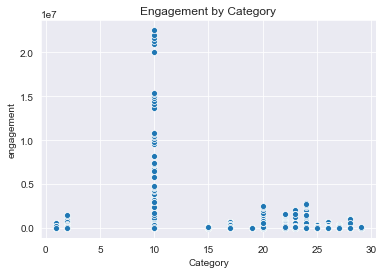

In [104]:
sns.set_style("darkgrid")
sns.scatterplot(data['categoryId'], data['engagement'])
plt.title("Engagement by Category")
plt.xlabel("Category")
plt.savefig("ebycat.png", dpi=300)

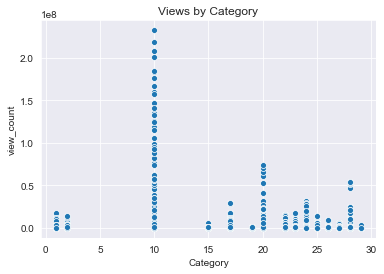

In [105]:
sns.scatterplot( data['categoryId'], data['view_count'])
plt.title("Views by Category")
plt.xlabel("Category")
plt.savefig("catbyview.png",dpi=300)

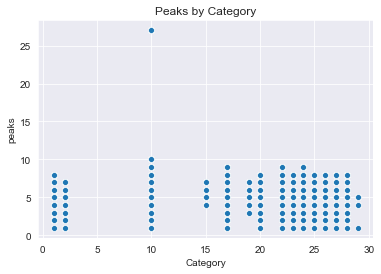

In [106]:
sns.scatterplot( data['categoryId'], data['peaks'])
plt.title("Peaks by Category")
plt.xlabel("Category")
plt.savefig("peaksbyview.png")

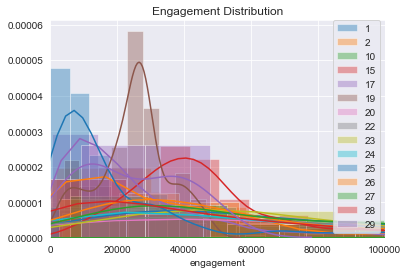

In [107]:
for i in categories:
    temp = data[data['categoryId'] == i]
    sns.distplot(temp['engagement'])
    
plt.xlim(0,100000)
plt.title("Engagement Distribution")
plt.legend(categories)
plt.savefig("EngDist", dpi=300)

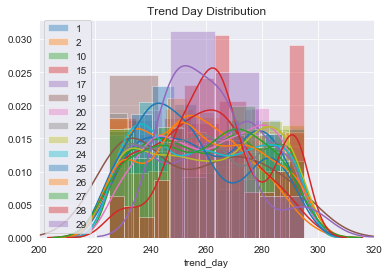

In [108]:
for i in categories:
    temp = data[data['categoryId'] == i]
    sns.distplot(temp['trend_day'])
    
plt.xlim(0,100000)
plt.title("Trend Day Distribution")
plt.xlim(200, 320)
plt.legend(categories)
plt.savefig("TrendDist", dpi=300)

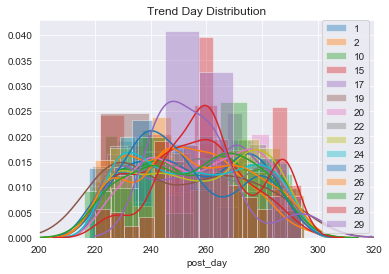

In [109]:
for i in categories:
    temp = data[data['categoryId'] == i]
    sns.distplot(temp['post_day'])
    
plt.xlim(0,100000)
plt.title("Trend Day Distribution")
plt.xlim(200, 320)
plt.legend(categories)
plt.savefig("TrendDayDist", dpi=300)

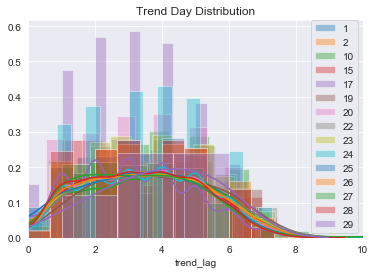

In [110]:
for i in categories:
    temp = data[data['categoryId'] == i]
    sns.distplot(temp['trend_lag'])
    
plt.xlim(0,100000)
plt.title("Trend Day Distribution")
plt.xlim(0, 10)
plt.legend(categories)
plt.savefig("TrendLagDist", dpi=300)

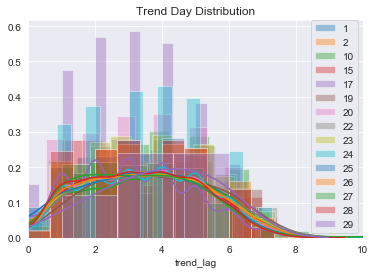

In [111]:
for i in categories:
    temp = data[data['categoryId'] == i]
    sns.distplot(temp['trend_lag'])
    
plt.xlim(0,100000)
plt.title("Trend Day Distribution")
plt.xlim(0, 10)
plt.legend(categories)
plt.savefig("TrendLagDist", dpi=300)

#### This is going to be an analytic proof of concept, but let us treat extra category trends as an anomaly relative to the internal category. That is, Category A is an anomaly in a field of all other trends, and by exclusion, non trending materials. We can try to use the engagement and other metrics to make this assessment. Testing below

In [112]:
def cat_flag(z, cat):
    if (z == cat):
        return 1
    else: 
        return 0

In [113]:
analysis = data.copy(deep=True)
analysis['flag'] = data.apply(lambda x: cat_flag(x['categoryId'], 10), axis=1)
analysis = analysis.drop(['video_id', 'channelTitle', 'tags'], axis=1)

In [114]:
labels = analysis['flag']
features = analysis.drop(['flag', 'categoryId', 'trend_date', 'post_date', 'post_time'],axis=1)

In [115]:
train_x, test_x, train_y, test_y = train_test_split(features,labels, test_size=.30, random_state=314)

In [116]:
test_y.value_counts()

0    3339
1     921
Name: flag, dtype: int64

In [130]:
1-(921/(3339+921))

0.7838028169014084

In [117]:
nb = GaussianNB()
nb.fit(train_x, train_y)
y_pred = nb.predict(test_x)
print(classification_report(test_y, y_pred))
confusion_matrix(test_y, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      3339
           1       0.55      0.14      0.22       921

    accuracy                           0.79      4260
   macro avg       0.68      0.55      0.55      4260
weighted avg       0.75      0.79      0.74      4260



array([[3236,  103],
       [ 794,  127]])

In [118]:
def recast(x):
    if (x == 1):
        return 0
    if (x==-1):
        return 1

In [119]:
rf = IsolationForest()
rf.fit(train_x, train_y)
y_pred = rf.predict(test_x)
y_pred = pd.Series(y_pred).apply(lambda x: recast(x))
print(classification_report(test_y, y_pred))
confusion_matrix(test_y, y_pred)

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      3339
           1       0.44      0.20      0.28       921

    accuracy                           0.77      4260
   macro avg       0.63      0.57      0.57      4260
weighted avg       0.73      0.77      0.74      4260



array([[3107,  232],
       [ 736,  185]])

##### None of these are particularly impressive, despite their general utility for this task. I was hoping by covering categorical AND purely numeric bases by Isolation Forest and NB, we'd cover all bases, but this isn't working, even with data that should in theory be indicative of trends after the fact.

### Neural Net Basic Attempt - No Normalization, just testing

In [131]:
nn = Sequential()
nn.add(Dense(32, input_dim=14))
nn.add(Dense(32, activation = "relu"))
nn.add(Dense(32, activation = "relu"))
nn.add(Dense(1, activation= "sigmoid"))
nn.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])

In [121]:
nn.fit(train_x, train_y, batch_size = 16, epochs = 10, verbose = 1)

Train on 9938 samples
Epoch 1/10
9938/9938 [==============================] - 1s 100us/sample - loss: nan - accuracy: 0.7648
Epoch 2/10
9938/9938 [==============================] - 1s 70us/sample - loss: nan - accuracy: 0.7658
Epoch 3/10
9938/9938 [==============================] - 1s 70us/sample - loss: nan - accuracy: 0.7658
Epoch 4/10
9938/9938 [==============================] - 1s 69us/sample - loss: nan - accuracy: 0.7658
Epoch 5/10
9938/9938 [==============================] - 1s 70us/sample - loss: nan - accuracy: 0.7658
Epoch 6/10
9938/9938 [==============================] - 1s 70us/sample - loss: nan - accuracy: 0.7658
Epoch 7/10
9938/9938 [==============================] - 1s 71us/sample - loss: nan - accuracy: 0.7658
Epoch 8/10
9938/9938 [==============================] - 1s 70us/sample - loss: nan - accuracy: 0.7658
Epoch 9/10
9938/9938 [==============================] - 1s 71us/sample - loss: nan - accuracy: 0.7658
Epoch 10/10
9938/9938 [==============================] - 1s

In [122]:
nn_score = nn.evaluate(test_x, test_y)

4260/4260 [==============================] - 0s 40us/sample - loss: nan - accuracy: 0.7838


No better than guessing by majority class, really. Shame

## Let's try on a different category

In [123]:
analysis['flag'] = data.apply(lambda x: cat_flag(x['categoryId'], 1), axis=1)
labels = analysis['flag']
features = analysis.drop(['flag', 'categoryId', 'trend_date', 'post_date', 'post_time'],axis=1)
train_x, test_x, train_y, test_y = train_test_split(features,labels, test_size=.30, random_state=314)

nb = GaussianNB()
nb.fit(train_x, train_y)
y_pred = nb.predict(test_x)
print(classification_report(test_y, y_pred))
confusion_matrix(test_y, y_pred)


              precision    recall  f1-score   support

           0       0.98      0.14      0.24      4089
           1       0.04      0.92      0.08       171

    accuracy                           0.17      4260
   macro avg       0.51      0.53      0.16      4260
weighted avg       0.94      0.17      0.23      4260



array([[ 559, 3530],
       [  13,  158]])

In [124]:
rf = IsolationForest()
rf.fit(train_x, train_y)
y_pred = rf.predict(test_x)
y_pred = pd.Series(y_pred).apply(lambda x: recast(x))
print(classification_report(test_y, y_pred))
confusion_matrix(test_y, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      4089
           1       0.01      0.02      0.01       171

    accuracy                           0.87      4260
   macro avg       0.48      0.47      0.47      4260
weighted avg       0.92      0.87      0.89      4260



array([[3710,  379],
       [ 167,    4]])

In [125]:
len(features.columns)

14

In [126]:
train_y.value_counts()
(1-(370/(9568+370)))

0.9627691688468505

In [127]:
nn = Sequential()
nn.add(Dense(32, input_dim=14))
nn.add(Dense(32, activation = "relu"))
nn.add(Dense(32, activation = "relu"))
nn.add(Dense(1, activation= "sigmoid"))
nn.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])

In [128]:
nn.fit(train_x, train_y, batch_size = 16, epochs = 10, verbose = 1)

Train on 9938 samples
Epoch 1/10
9938/9938 [==============================] - 1s 98us/sample - loss: nan - accuracy: 0.9616
Epoch 2/10
9938/9938 [==============================] - 1s 70us/sample - loss: nan - accuracy: 0.9628
Epoch 3/10
9938/9938 [==============================] - 1s 71us/sample - loss: nan - accuracy: 0.9628
Epoch 4/10
9938/9938 [==============================] - 1s 70us/sample - loss: nan - accuracy: 0.9628
Epoch 5/10
9938/9938 [==============================] - 1s 68us/sample - loss: nan - accuracy: 0.9628
Epoch 6/10
9938/9938 [==============================] - 1s 70us/sample - loss: nan - accuracy: 0.9628
Epoch 7/10
9938/9938 [==============================] - 1s 71us/sample - loss: nan - accuracy: 0.9628
Epoch 8/10
9938/9938 [==============================] - 1s 70us/sample - loss: nan - accuracy: 0.9628
Epoch 9/10
9938/9938 [==============================] - 1s 71us/sample - loss: nan - accuracy: 0.9628
Epoch 10/10
9938/9938 [==============================] - 1s 

In [129]:
nn_score = nn.evaluate(test_x, test_y)

4260/4260 [==============================] - 0s 43us/sample - loss: nan - accuracy: 0.9599


#### Still bad, doesn't look like we can use the assumptions above to detect anomalies; We likely need the trend data. This is explored again by subsetting in NoteBook 3